# Required Libraries 

In [6]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler,OneHotEncoder,MinMaxScaler
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier 

# Load Dataset

In [7]:
df=pd.read_csv('loan_dataset.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# Missing Values 

In [8]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

# Dataset Info

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


# Feature Engineering 

In [10]:
df['Total_Income']=df['CoapplicantIncome'] + df['ApplicantIncome']
df['EMI']=df['LoanAmount'] / df['Loan_Amount_Term']
df['BalanceIncome']=df['Total_Income'] - (df['EMI'] *1000 )
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income,EMI,BalanceIncome
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,5849.0,NaN,NaN
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,6091.0,0.355556,5735.444444
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,3000.0,0.183333,2816.666667
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,4941.0,0.333333,4607.666667
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,6000.0,0.391667,5608.333333


# Encoding Target Column 

In [11]:
le=LabelEncoder()
df['Loan_Status']=le.fit_transform(df['Loan_Status'])


In [12]:
num_col=['ApplicantIncome','BalanceIncome','EMI','Total_Income','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History']
cat_col=['Gender','Married','Dependents','Education','Self_Employed','Property_Area']

# Feature 

In [13]:
X=df.drop(['Loan_Status','Loan_ID' ],axis=1)
y=df['Loan_Status']

# ColumnTransformer

In [14]:
preprocessor=ColumnTransformer([
    ('num',Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
    ]),num_col),
    
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('enco', OneHotEncoder())
    ]),cat_col)
])

# Classifiers Models 

In [15]:
clf1=XGBClassifier(n_estimators=300,learning_rate=0.01,
                           max_depth=3,scale_pos_weight=0.4549763033175355,
                          random_state=42, subsample=0.3,colsample_bytree=1.0
                          ,reg_lambda=0.8,reg_alpha=0.4,objective='binary:logistic',
                  eval_metric='logloss')

clf2=LogisticRegression(max_iter=500,
                               penalty='l2',tol=0.001,
                               random_state=42,solver='lbfgs')

clf3=RandomForestClassifier(n_estimators=800, random_state=42,
                                   )

# Voting Classifier

In [16]:
voting_clf=VotingClassifier(
    estimators=[
    ('xgb',clf1),
    ('lr',clf2),
    ('rfc',clf3)
    ],voting='soft'
)

# PipeLine

In [17]:
pipe=Pipeline([
    ('pre',preprocessor ),
    ('sm',SMOTE(random_state=42)),
    ('voting',voting_clf)
])

# Split Data 

In [18]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

# Fit And Predict

In [19]:
pipe.fit(X_train, y_train)
y_pred=pipe.predict(X_test)

# Accuracy 

In [20]:
print('Accuracy :', accuracy_score(y_test, y_pred))

Accuracy : 0.7297297297297297


# Classification Report 

In [21]:
print('Classification Report :')
print(classification_report(y_test, y_pred))

Classification Report :
              precision    recall  f1-score   support

           0       0.63      0.57      0.60        65
           1       0.78      0.82      0.80       120

    accuracy                           0.73       185
   macro avg       0.70      0.69      0.70       185
weighted avg       0.72      0.73      0.73       185



# Confusion Matrix 

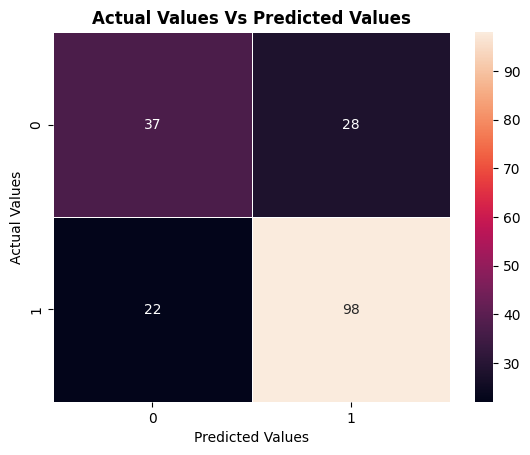

In [22]:
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', linewidth=0.5)
plt.title('Actual Values Vs Predicted Values', fontweight='bold')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()